# Run Trotterization on ibmq_jakarta

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
import pickle
# plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_69370/4110962823.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("./")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [7]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps = 100
print("trotter step: ", num_steps)

trotter step:  100


# Make Quantum Circuit

In [8]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(num_qubits, name="lq")
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
subspace_decoder_init110(qc, targets=[0, 1, 2]) # decode

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time / num_steps})
print("created qc")

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
print("created st_qcs (length:", len(st_qcs), ")")

# remove barriers
st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
print("removed barriers from st_qcs")

# optimize circuit
t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

t3_st_qcs = transpile(t3_st_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
print("created t3_zne_qcs (length:", len(t3_st_qcs), ")")

created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created t3_zne_qcs (length: 27 )


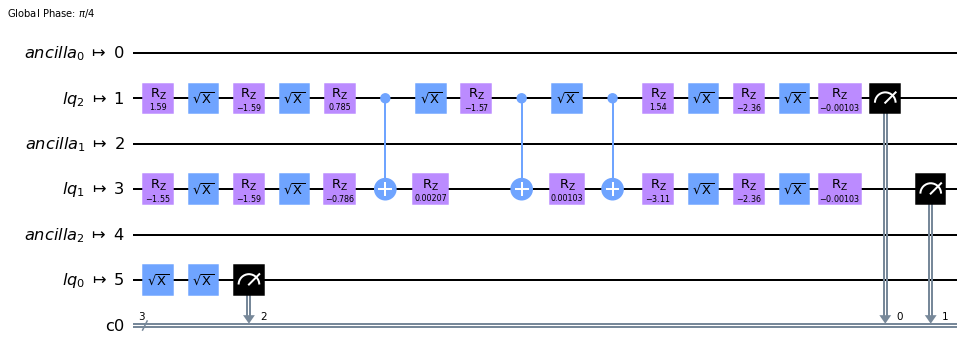

In [9]:
t3_st_qcs[-1].draw("mpl")  # only view trotter gates

# Set Backend

In [10]:
# from qiskit.test.mock import FakeJakarta
# backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
print("provider:", provider)
backend = provider.get_backend("ibmq_jakarta")

provider: <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>


# Set Execute Options

In [11]:
shots = 8192
reps = 8

In [12]:
jobs = []
for _ in range(reps):
    # execute
    job = execute(t3_st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6255345f9def42a1c8a9895a
Job ID 62553462d66fd64f93a947d7
Job ID 625534639def42c914a9895b
Job ID 625534658b86e9525dc0d15a
Job ID 62553467d8e31ac6f38b4c74
Job ID 625534688233e8eaa3ad1a28
Job ID 6255346ad7294bf11a9f12f3
Job ID 6255346cbca2b94be377bcb7


# QREM

In [11]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [13]:
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout=initial_layout)
print('Job ID', cal_job.job_id())

Job ID 6255346d9def421038a9895c


In [14]:
dt_now = datetime.datetime.now()
print(dt_now)

2022-04-12 17:12:48.439364


In [15]:
with open("jobs_jakarta_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_35638/2345955454.py:2: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)


In [16]:
with open("job_ids_jakarta_100step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"job_ids": [job.job_id() for job in jobs], "cal_job_id": cal_job.job_id()}, f)

In [17]:
with open("properties_jakarta" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump(backend.properties(), f)

# ====== wait for the job ======

In [12]:
filename = "job_ids_jakarta_100step_20220412_171248_.pkl" # change here
with open(filename, "rb") as f:
    job_ids_dict = pickle.load(f)
    job_ids = job_ids_dict["job_ids"]
    cal_job_id = job_ids_dict["cal_job_id"]

In [13]:
retrieved_jobs = []
for job_id in job_ids:
    retrieved_jobs.append(backend.retrieve_job(job_id))
retrieved_cal_job = backend.retrieve_job(cal_job_id)

# State Tomography

In [14]:
cal_results = retrieved_cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

In [15]:
# set the target state
target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

In [16]:
fids = []
for job in retrieved_jobs:
    # mit_results = meas_fitter.filter.apply(job.result()) # apply QREM
    rho = StateTomographyFitter(job.result(), st_qcs).fit(method='lstsq')
    fid = state_fidelity(rho, target_state)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.8852 ± 0.0035


In [18]:
import qiskit.tools.jupyter
%qiskit_version_table